In [1]:
import tensorflow as tf
import os

In [2]:
os.listdir('data')

['dogs', 'cats']

In [3]:
gpus = tf. config.experimental.list_physical_devices ("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [4]:
import cv2
import imghdr


In [5]:
dataDir = 'data'
os.listdir(dataDir)


['dogs', 'cats']

In [6]:
imageExts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(dataDir):
    for image in os.listdir(os.path.join(dataDir, image_class)):
        image_path = os.path.join(dataDir,image_class,image)
        try:
            img = cv2. imread(image_path)
            tip = imghdr. what (image_path)
            if tip not in imageExts:
                print ('Image not in ext list{}'.format (image_path))
                os.remove (image_path)
        except Exception as e:
            print('Issue with image{}'.format (image_path))

In [8]:
import numpy as np
from matplotlib import pyplot as plt


In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 9415 files belonging to 2 classes.


2024-01-04 03:52:12.680929: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-01-04 03:52:12.680964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-04 03:52:12.680967: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-04 03:52:12.681003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-04 03:52:12.681019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
dataIterator = data.as_numpy_iterator()


In [11]:
batch = dataIterator.next()

batch[1]

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int32)

In [12]:
#Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

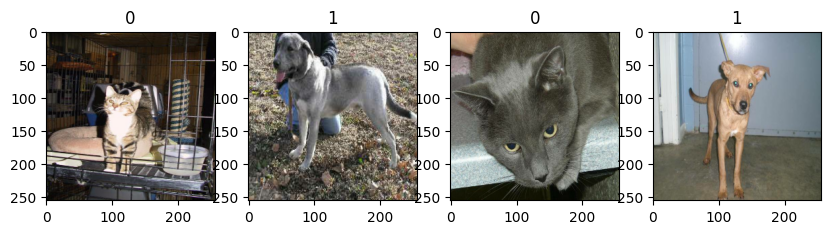

In [13]:
#0 is cat
#1 is dog

fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, image in enumerate(batch[0][:4]):
    ax[idx].imshow(image.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    

In [14]:
scaled = batch[0]/255

In [15]:
scaled_data = data.map(lambda x,y:(x/255,y))

In [16]:
scaled_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
scaledIterator = scaled_data.as_numpy_iterator().next()

In [18]:
scaledIterator[0].max()

1.0

In [19]:
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1) +1

In [20]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size + val_size).take(test_size)

In [21]:
from keras import Sequential

from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from keras.regularizers import l2

In [22]:
model = Sequential()

# Add Convolutional and Pooling layers
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers with Dropout and L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Adjusted L2 regularization strength
model.add(Dropout(0.6))  # Increasing dropout rate to 0.5

model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Adjusted L2 regularization strength


In [23]:
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with the custom optimizer
model.compile(optimizer=custom_optimizer, 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [25]:
logdir = 'log'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100


2024-01-04 03:52:14.025943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-04 03:52:14.078361: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


206/206 [==============================] - 14s 62ms/step - loss: 1.1543 - accuracy: 0.5404 - val_loss: 1.0012 - val_accuracy: 0.5927
Epoch 2/100
206/206 [==============================] - 13s 62ms/step - loss: 0.9134 - accuracy: 0.5678 - val_loss: 0.8372 - val_accuracy: 0.6107
Epoch 3/100
206/206 [==============================] - 13s 63ms/step - loss: 0.7950 - accuracy: 0.6171 - val_loss: 0.7540 - val_accuracy: 0.6483
Epoch 4/100
206/206 [==============================] - 13s 62ms/step - loss: 0.7238 - accuracy: 0.6594 - val_loss: 0.6937 - val_accuracy: 0.6833
Epoch 5/100
206/206 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.6984

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

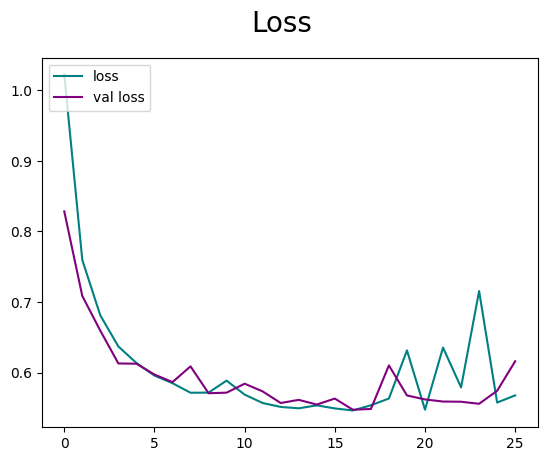

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color = 'teal', label = 'loss')
plt.plot(history.history['val_loss'], color = 'purple', label = 'val loss')

plt.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show

If loss is going down but val loss is rising, its a sign that model is overfitting (apply regularization)

If loss is not decreasing at all, look at the data again, or use a larger or more sophisticated neural network

<function matplotlib.pyplot.show(close=None, block=None)>

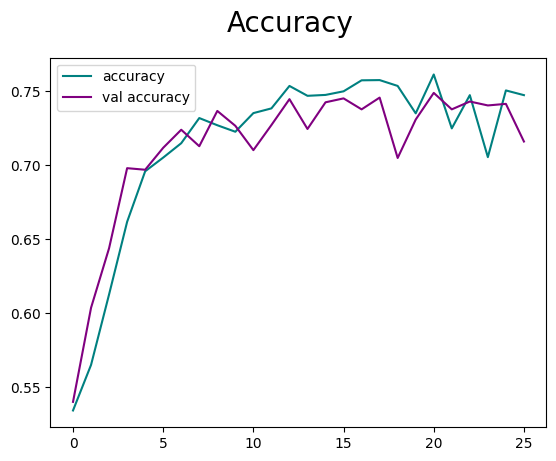

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'purple', label = 'val accuracy')

plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show

In [ ]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
precision = Precision()
recall = Recall()
biAcc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    biAcc.update_state(y, yhat)


1/1 [==============================] - 0s 79ms/step


In [ ]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{biAcc.result().numpy()}')

Precision:0.748251736164093, Recall:0.8508946299552917, Accuracy:0.7657753825187683


In [ ]:
import cv2


1/1 [==============================] - 0s 41ms/step


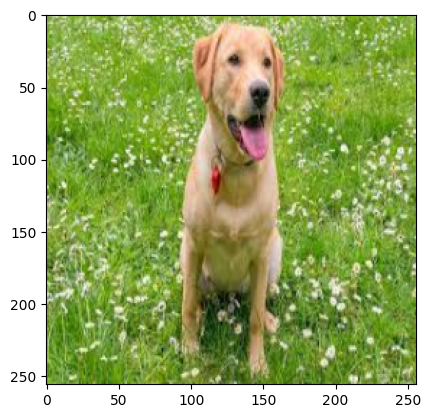

In [ ]:
img = cv2.imread('dogtest2.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

plt.show

yhat = model.predict(np.expand_dims(resize/255,0))


In [ ]:
if yhat > 0.5:
    print("It's a dog")

else:
    print("It's a cat")

It's a dog


In [ ]:
# from keras.models import load_model
# model.save(os.path.join('models','Cats&DogsClassifier.h5'))

# newModel = load_model(os.path.join('models', 'Cats&DogsClassifier.h5'))

In [ ]:
# img = cv2.imread('dogtest2.jpeg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)

# resize = tf.image.resize(img, (256,256))
# plt.imshow(resize.numpy().astype(int))

# plt.show

# yhat = newModel.predict(np.expand_dims(resize/255,0))

In [ ]:
# yhat

In [ ]:
# if yhat > 0.5:
#     print("It's a dog")

# else:
#     print("It's a cat")